# 50.040 Natural Language Processing (Fall 2024) Homework 3

**Due 29 November 2024, 23:59 PM**


### STUDENT ID: 1006184

### Name: Atul Parida

### Students with whom you have discussed (if any):

In [1]:
%pip install d2l
import math
import torch
from torch import nn
from d2l import torch as d2l

Note: you may need to restart the kernel to use updated packages.


Previous deep learning methods use architectures like multilayer perceptron, convolutional network, and recurrent network. In recent years, Transformer-based models are the leading approach for nearly all natural language processing tasks. The Transformer model is built on the attention mechanism, which was initially designed as an improvement for encoder-decoder RNNs in sequence-to-sequence tasks like machine translation. In this homework, we will begin with the attention mechanism and gradually progress to understanding Transformers.

## Attention Mechanisms

Consider the following: denote by $\mathcal{D} = \{(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)\}$ a database of $m$ tuples of *keys* and *values*. Moreover, denote by $\mathbf{q}$ a *query*. Then we can define the *attention* over $\mathcal{D}$ as

$$
\text{Attention}(\mathbf{q}, \mathcal{D}) = \sum_{i=1}^{m} \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i
$$

where $\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathcal{R}$ $(i = 1, \ldots, m)$ are scalar attention weights. This operation is commonly known as *attention pooling*. The term *attention* reflects the mechanism’s ability to focus on specific elements in the dataset, assigning higher weights $\alpha$ to the terms in $\mathcal{D}$ that are deemed more relevant or significant. Consequently, the attention mechanism produces a weighted linear combination of the values in the database, emphasizing the most important components.

A common strategy for ensuring that the weights sum up to 1 is to normalize them via

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\alpha(\mathbf{q}, \mathbf{k}_i)}{\sum_j \alpha(\mathbf{q}, \mathbf{k}_j)}.
$$

In particular, to ensure that the weights are also nonnegative, one can resort to exponentiation. This means that we can now pick any function $a(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it via

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_j \exp(a(\mathbf{q}, \mathbf{k}_j))}.
$$

Then, we need to keep the order of magnitude of the arguments in the exponential function under control. Assume that all the elements of the query $\mathbf{q} \in \mathcal{R}^d$ and the key $\mathbf{k}_i \in \mathcal{R}^d$ are independent and identically drawn random variables with zero mean and unit variance. The dot product between both vectors has zero mean and a variance of $d$. To ensure that the variance of the dot product still remains 1 regardless of vector length, we use the *scaled dot product attention* scoring function. That is, we rescale the dot product by $1/\sqrt{d}$. We thus arrive at the first commonly used attention function that is used:

$$
a(\mathbf{q}, \mathbf{k}_i) = \frac{\mathbf{q}^\top \mathbf{k}_i}{\sqrt{d}}.
$$

Note that attention weights $\alpha$ still need normalizing. We can simplify this further via the softmax operation:

$$
\alpha(\mathbf{q}, \mathbf{k}_i) = \text{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(\mathbf{q}^\top \mathbf{k}_i / \sqrt{d})}{\sum_{j=1}^m \exp(\mathbf{q}^\top \mathbf{k}_j / \sqrt{d})}.
$$

### Question 1 [code] (5 points)
One of the most popular applications of the attention mechanism is to sequence models. For example, assume that we have the following three sentences with different length:

| Study | about | Deep    | Learning  |
|-------|-------|---------|-----------|
| Start | by    | code    | `<blank>` |
| Hello | world | `<blank>` | `<blank>` |

Implement the function ``masked_softmax`` that deals with sequences of different lengths. Then, run the sanity check cell to check your implementation.

In [2]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    ### YOUR CODE HERE
    # Hint: On the last axis, replace masked elements with a very large negative value, whose exponentiation outputs 0
    if valid_lens.dim() == 1:
        valid_lens = valid_lens.repeat(X.shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    shape = X.shape
    ### END OF YOUR CODE
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
# sanity check
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.3086, 0.2441, 0.2017, 0.2455],
         [0.2703, 0.1696, 0.1754, 0.3848]],

        [[0.2493, 0.2589, 0.3158, 0.1760],
         [0.2233, 0.1733, 0.2717, 0.3317]]])

### Question 2 (9 points)
In practice, we often think of minibatches for efficiency, such as computing attention for $n$ queries and $m$ key-value pairs, where queries and keys are of length $d$ and values are of length $v$. The scaled dot product attention of queries $\mathbf{Q} \in \mathcal{R}^{n \times d}$, keys $\mathbf{K} \in \mathcal{R}^{m \times d}$, and values $\mathbf{V} \in \mathcal{R}^{m \times v}$ thus can be written as

$$
\text{softmax} \left( \frac{\mathbf{Q}\mathbf{K}^\top}{\sqrt{d}} \right) \mathbf{V} \in \mathcal{R}^{n \times v}.
$$

**Question 2.1 [written] (4 points)** Write the shape of queries, keys and values during the calculation of scaled dot product attention. You should fill in the shape inside the code box.

**Question 2.2 [code] (5 points)** Implement function ``DotProductAttention`` that calculates the scaled dot product attention. Then, run the sanity check cell to check your implementation.

In [6]:
class DotProductAttention(nn.Module):  #@save
    """Scaled dot product attention."""
    def __init__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: 
    # Shape of keys: 
    # Shape of values: 
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        ### YOUR CODE HERE
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        ### END OF YOUR CODE
        return torch.bmm(self.dropout(self.attention_weights), values)

In [7]:
# sanity check
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
values = torch.normal(0, 1, (2, 10, 4))
valid_lens = torch.tensor([2, 6])

attention = DotProductAttention(dropout=0.5)
attention.eval()
d2l.check_shape(attention(queries, keys, values, valid_lens), (2, 1, 4))
print("Pass!")

Pass!


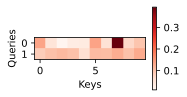

In [8]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## Attention Seq2Seq
Attention mechanisms can be effectively integrated into encoder-decoder architectures for sequence-to-sequence learning. Traditionally, in an RNN-based approach, all relevant information from the source sequence is encoded into a fixed-dimensional state representation by the encoder. However, rather than maintaining this state—represented by the context variable $\mathbf{c}$ that summarizes the source sentence—as a fixed value, it can be dynamically updated. This update is based on both the original text (encoder hidden states $\mathbf{h}_{t}$) and the previously generated text (decoder hidden states $\mathbf{s}_{t’-1}$). As a result, we obtain an updated context variable $\mathbf{c}_{t’}$ after each decoding time step $t’$. This approach allows the model to adapt the context dynamically, even for input sequences of length $T$, thereby improving the ability to handle long-range dependencies and capture more nuanced information from the source sequence.
In this case, the context variable is the output of attention pooling:

\begin{equation}
\mathbf{c}_{t'} = \sum_{t=1}^{T} \alpha(\mathbf{s}_{t'-1}, \mathbf{h}_t) \mathbf{h}_t.
\end{equation}

We used $\mathbf{s}_{t'-1}$ as the query, and $\mathbf{h}_t$ as both the key and the value. Note that $\mathbf{c}_{t'}$ is then used to generate the state $\mathbf{s}_{t'}$ and to generate a new token.

### Question 3 [code] (6 points)
Implement the RNN decoder in the ``Seq2SeqAttentionDecoder`` class. The decoder’s state is initialized using three components: 

(i) the hidden states of the encoder’s last layer across all time steps, which are utilized as keys and values for the attention mechanism; 

(ii) the hidden state of the encoder’s final time step at all layers, which initializes the decoder’s hidden state; and 

(iii) the valid length of the encoder to exclude padding tokens during attention pooling. During each decoding time step, the hidden state of the decoder’s final layer from the previous step is used as the query for the attention mechanism. The attention mechanism’s output is then concatenated with the input embedding to form the input for the RNN decoder, effectively guiding the generation process with context from both the source sequence and previous decoder outputs.

Then, run the sanity check cell to check your implementation.

In [9]:
class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [10]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        ### YOUR CODE HERE

        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(query, enc_outputs, enc_outputs,
                                     enc_valid_lens)
            x = torch.cat((torch.squeeze(context, dim=1), torch.squeeze(x, dim=1)), dim=1)
            out, hidden_state = self.rnn(x.unsqueeze(0), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        outputs = self.dense(torch.cat(outputs, dim=0))

        ### END OF YOUR CODE
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [30]:
# sanity check
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 7
encoder = d2l.Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
decoder = Seq2SeqAttentionDecoder(vocab_size, embed_size, num_hiddens,
                                  num_layers)
X = torch.zeros((batch_size, num_steps), dtype=torch.long)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
d2l.check_shape(output, (batch_size, num_steps, vocab_size))
d2l.check_shape(state[0], (batch_size, num_steps, num_hiddens))
d2l.check_shape(state[1][0], (batch_size, num_hiddens))
print("Pass!")

Pass!


## Multihead Attention
Rather than relying on a single attention pooling operation, the queries, keys, and values can be transformed through $h$ independently learned linear projections. These $h$ projected queries, keys, and values are then processed in parallel through attention pooling. Afterward, the $h$ resulting attention outputs, known as ``heads``, are concatenated and passed through another learned linear projection to generate the final output. This architecture, referred to as ``multi-head attention``, allows each attention head to focus on different parts of the input, enabling the model to capture a wider range of information.

![Multihead attention](Multihead_attention.png)

Given a query $\mathbf{q} \in \mathcal{R}^{d_q}$, a key $\mathbf{k} \in \mathcal{R}^{d_k}$, and a value $\mathbf{v} \in \mathcal{R}^{d_v}$, each attention head $\mathbf{h}_i$ $(i = 1, \ldots, h)$ is computed as:

\begin{equation}
\mathbf{h}_i = f(\mathbf{W}_i^{(q)} \mathbf{q}, \mathbf{W}_i^{(k)} \mathbf{k}, \mathbf{W}_i^{(v)} \mathbf{v}) \in \mathcal{R}^{p_v},
\end{equation}

where $\mathbf{W}_i^{(q)} \in \mathcal{R}^{p_q \times d_q}$, $\mathbf{W}_i^{(k)} \in \mathcal{R}^{p_k \times d_k}$, and $\mathbf{W}_i^{(v)} \in \mathcal{R}^{p_v \times d_v}$ are learnable parameters and $f$ is attention pooling. The multi-head attention output is another linear transformation via learnable parameters $\mathbf{W}_o \in \mathcal{R}^{p_o \times hp_v}$ of the concatenation of $h$ heads:

\begin{equation}
\mathbf{W}_o 
\begin{bmatrix}
\mathbf{h}_1 \\
\vdots \\
\mathbf{h}_h
\end{bmatrix}
\in \mathcal{R}^{p_o}. 
\end{equation}

Based on this design, each head may attend to different parts of the input. More sophisticated functions than the simple weighted average can be expressed.

### Question 4 [written] (4 points)
Please describe the benefits of using multi-head attention instead of single head attention.

**Write your answer here**

In practice, given the same set of queries, keys, and values we may want our model to combine knowledge from different behaviors of the same attention mechanism, such as capturing dependencies of various ranges (e.g., shorter-range vs. longer-range) within a sequence. Thus, it may be beneficial to allow our attention mechanism to jointly use different representation subspaces of queries, keys, and values.

### Question 5 [code] (12 points)
In this implementation, we choose the scaled dot product attention for each head of the multi-head attention. To avoid significant growth of computational cost and parameterization cost, we set $p_q = p_k = p_v = p_o / h$. Note that $h$ heads can be computed in parallel if we set the number of outputs of linear transformations for the query, key, and value to $p_qh = p_kh = p_vh = p_o$. In the following implementation, $p_o$ is specified via the argument ``num_hiddens``.


To allow for parallel computation of multiple heads, the ``MultiHeadAttention`` class uses two transposition methods ``transpose_output`` and ``transpose_output``. Specifically, the ``transpose_output`` method reverses the operation of the ``transpose_qkv`` method.

**Question 5.1 [code] (4 points)** Implement function ``transpose_qkv``, which is the transposition for parallel computation of multiple attention heads.

**Question 5.2 [code] (4 points)** Implement function ``transpose_output`` that reverse the operation of ``transpose_qkv``.

**Question 5.3 [code] (4 points)**
Complete `MultiHeadAttention` class. (Hint: you can use the two function you defined in question 5.1 and 5.2 .)

In [ ]:
class MultiHeadAttention(d2l.Module):  #@save
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        
        ### YOUR CODE HERE

        ### END OF YOUR CODE
        return self.W_o(output_concat)

In [32]:
@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)

    ### YOUR CODE HERE
    for i in range(self.num_heads):
        X[i] = self.W_q(X[i])
        X[i] = self.W_k(X[i])
        X[i] = self.W_v(X[i])

    ### END OF YOUR CODE
    return 

@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    
    ### YOUR CODE HERE
    for i in range(self.num_heads):
        X[i] = self.W_o(X[i])

    ### END OF YOUR CODE
    return 

In [33]:
# sanity check
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
d2l.check_shape(attention(X, Y, Y, valid_lens),
                (batch_size, num_queries, num_hiddens))
print("Pass!")

TypeError: 'NoneType' object is not callable

## Self-Attention and Positional Encoding
In self-attention, the queries, keys, and values are represented as $n \times d$ matrices, where $n$ is the sequence length and $d$ is the feature dimension. The scaled dot-product attention operates by first multiplying an $n \times d$ query matrix by a $d \times n$ key matrix, producing an $n \times n$ output. This output is then multiplied by an $n \times d$ value matrix, resulting in another $n \times d$ matrix. Consequently, the self-attention mechanism has a computational complexity of $\mathcal{O}(n^2 d)$. Since each token can attend to every other token in the sequence, self-attention provides direct connections between all tokens, enabling parallel computation with $\mathcal{O}(1)$ sequential operations and a maximum path length of $\mathcal{O}(1)$. However, the quadratic complexity with respect to the sequence length ($n^2$) makes self-attention computationally expensive and impractical for very long sequences, significantly slowing down processing in such cases.

Unlike RNNs, which process tokens sequentially, self-attention eliminates the need for sequential operations by leveraging parallel computation. However, self-attention alone does not inherently capture the order of tokens in a sequence. So, what happens when the order of the input matters? The standard solution is to introduce \textit{positional encodings}—additional information associated with each token to indicate its position in the sequence. These positional encodings can either be learned during training or predefined in advance. By incorporating this positional information, the model gains awareness of the token order, allowing it to preserve sequence structure while benefiting from the parallelism of self-attention.

Suppose that the input representation $\mathbf{X} \in \mathcal{R}^{n \times d}$ contains the $d$-dimensional embeddings for $n$ tokens of a sequence. The positional encoding outputs $\mathbf{X} + \mathbf{P}$ using a positional embedding matrix $\mathbf{P} \in \mathcal{R}^{n \times d}$ of the same shape, whose element on the $i^{\text{th}}$ row and the $(2j)^{\text{th}}$ or the $(2j+1)^{\text{th}}$ column is

\begin{equation}
p_{i, 2j} = \sin \left( \frac{i}{10000^{2j/d}} \right), \quad
p_{i, 2j+1} = \cos \left( \frac{i}{10000^{2j/d}} \right).
\end{equation}

### Question 6 [code] (4 points)
Implement the ``PositionalEncoding`` class. Then, run the sanity check cell to check your implementation.

In [ ]:
class PositionalEncoding(nn.Module):  #@save
    """Positional encoding."""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        ### YOUR CODE HERE
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

        ### END OF YOUR CODE

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [ ]:
# sanity check
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])